# Implement a true brute force 

In [222]:
from roboqueue import StationaryTarget, TargetList, Telescope, Conditions

import numpy as np
from spacerocks.utils import time_handler

import itertools

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [223]:
telescope = Telescope(obscode='W84', filter='r')
conditions = Conditions(seeing=1, moon=7)

In [224]:
star_positions = [( 24.42813204, -57.23666007), 
                  ( 68.98000195,  16.50976164),
                  ( 78.63446353,  -8.20163919), 
                  ( 79.17206517,  45.99902927),
                  ( 88.79287161,   7.40703634), 
                  ( 95.98787763, -52.69571799),
                  (101.28854105, -16.71314306), 
                  (114.82724194,   5.22750767),
                  #(186.64975585, -63.09905586), 
                  #(210.95601898, -60.3729784 ),
                  (219.92041034, -60.83514707)]

# convert to radians    
star_positions = [(np.radians(ra), np.radians(dec)) for ra, dec in star_positions]

In [248]:
targets = TargetList()

for star in star_positions:
    target = StationaryTarget(ra=star[0], dec=star[1], mag=1, required_snr=3_000_000)
    targets.add_target(target)

In [249]:
# generate an iterator for all possible combinations of targets.targets
combos = itertools.permutations(targets.targets)

In [250]:
t0 = time_handler('12 February 2024 at 2 am').utc.jd[0]

In [251]:
durations = []

fastest_time = 1e10
fastest_combo = None
fastest_epochs = None

for combo in combos:
    epoch = t0

    targets.targets = combo
    duration = 0

    obs_epochs = []
    for target in targets.targets:
        epoch = t0 + duration / 86400
        _, _, _, _, exptime = target.at(epoch, telescope, conditions)
        obs_epochs.append(epoch)
        duration += exptime

    if duration < fastest_time:
        fastest_time = duration
        fastest_combo = combo
        fastest_epochs = obs_epochs

    durations.append(duration)

Text(0.5, 1.0, 'Observation duration for all possible combinations of 9 targets')

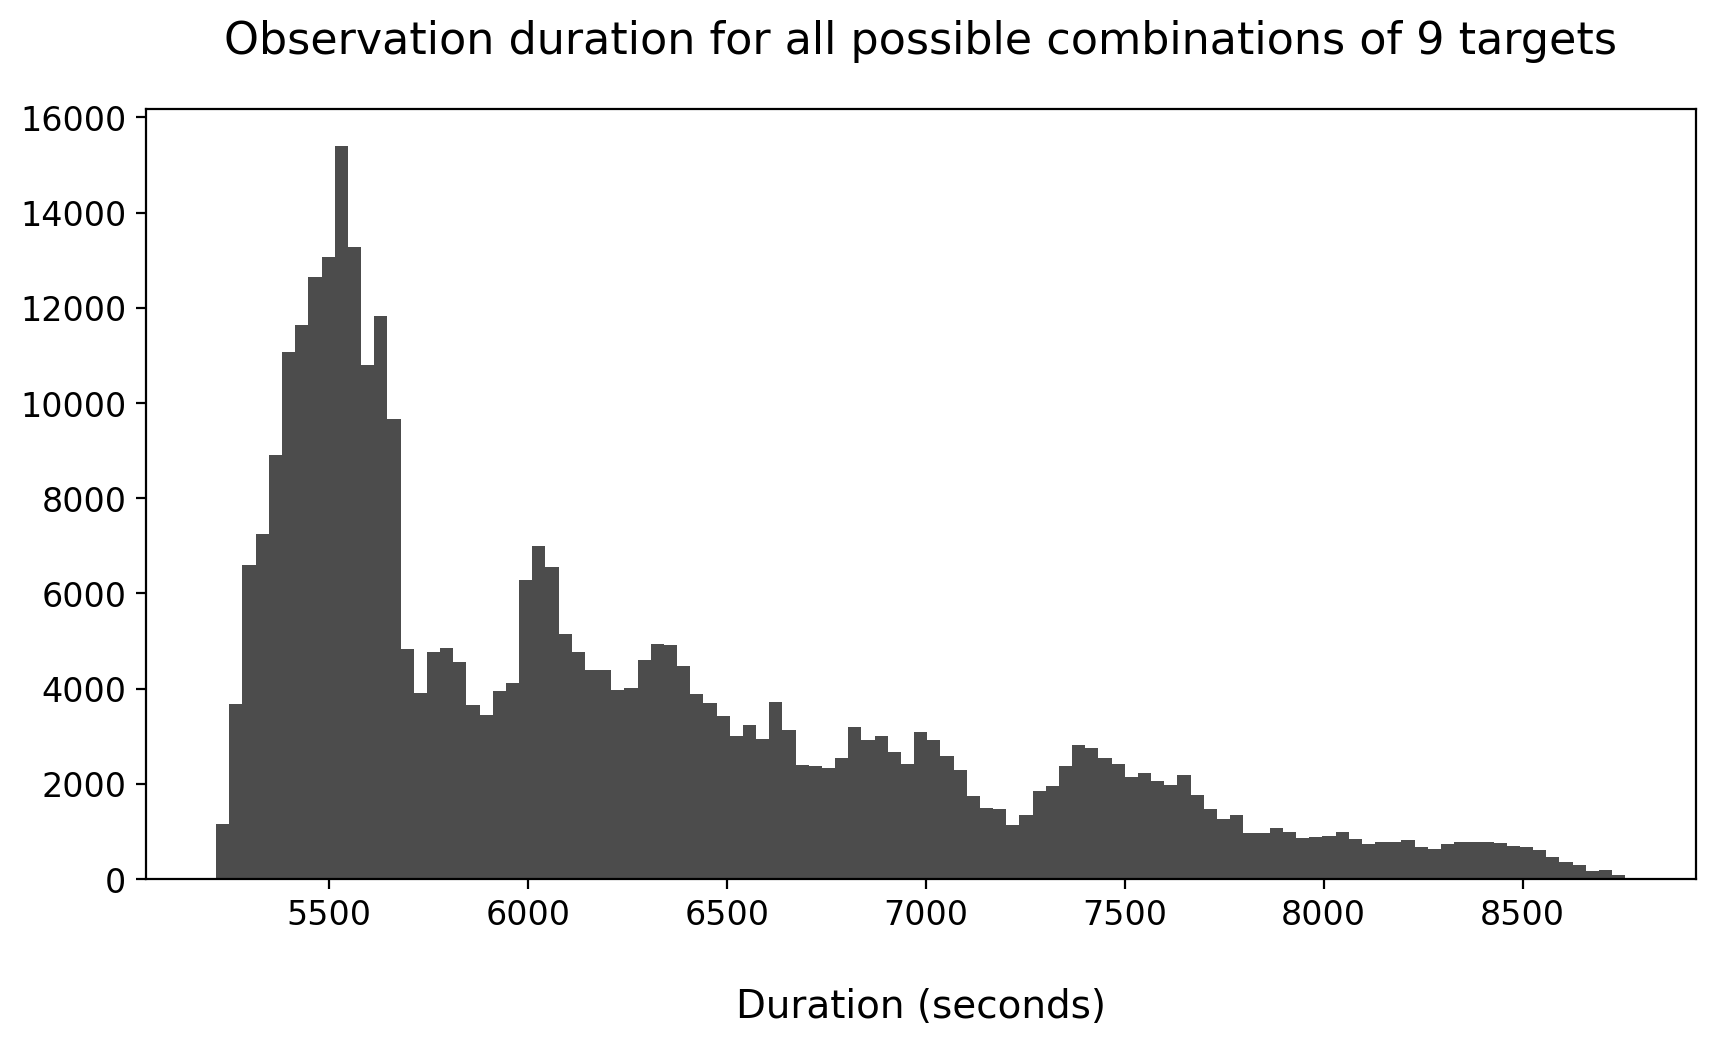

In [252]:
fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.hist(durations, bins='auto', color='k', alpha=0.7)
ax.set_xlabel('Duration (seconds)', fontsize=14, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_title(f'Observation duration for all possible combinations of {len(targets.targets)} targets', fontsize=16, pad=20)

In [253]:
from roboqueue.airmass import calculate_airmass
from roboqueue.altaz import calc_altaz

In [254]:
times = np.linspace(t0, t0 + fastest_time/86400, 1000)

In [255]:
fastest_time/86400

0.060377370197954736

In [256]:
airmasses = {idx: [] for idx in range(len(fastest_combo))}

for idx, target in enumerate(fastest_combo):
    for t in times:
        alt, az = calc_altaz(target.ra, target.dec, telescope.lat, telescope.lon, t)
        airmass = calculate_airmass(alt)
        airmasses[idx].append(airmass)


In [257]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

In [284]:
np.argmin(times - fastest_epochs[idx])

0

In [286]:
times - fastest_epochs[idx]

array([-5.25435549e-02, -5.24831172e-02, -5.24226795e-02, -5.23622413e-02,
       -5.23018036e-02, -5.22413659e-02, -5.21809282e-02, -5.21204905e-02,
       -5.20600523e-02, -5.19996146e-02, -5.19391769e-02, -5.18787391e-02,
       -5.18183014e-02, -5.17578633e-02, -5.16974255e-02, -5.16369878e-02,
       -5.15765501e-02, -5.15161124e-02, -5.14556742e-02, -5.13952365e-02,
       -5.13347988e-02, -5.12743611e-02, -5.12139234e-02, -5.11534852e-02,
       -5.10930475e-02, -5.10326098e-02, -5.09721721e-02, -5.09117339e-02,
       -5.08512962e-02, -5.07908585e-02, -5.07304207e-02, -5.06699830e-02,
       -5.06095449e-02, -5.05491071e-02, -5.04886694e-02, -5.04282317e-02,
       -5.03677940e-02, -5.03073558e-02, -5.02469181e-02, -5.01864804e-02,
       -5.01260427e-02, -5.00656050e-02, -5.00051668e-02, -4.99447291e-02,
       -4.98842914e-02, -4.98238537e-02, -4.97634159e-02, -4.97029778e-02,
       -4.96425400e-02, -4.95821023e-02, -4.95216646e-02, -4.94612269e-02,
       -4.94007887e-02, -

Text(0, 0.5, 'Airmass')

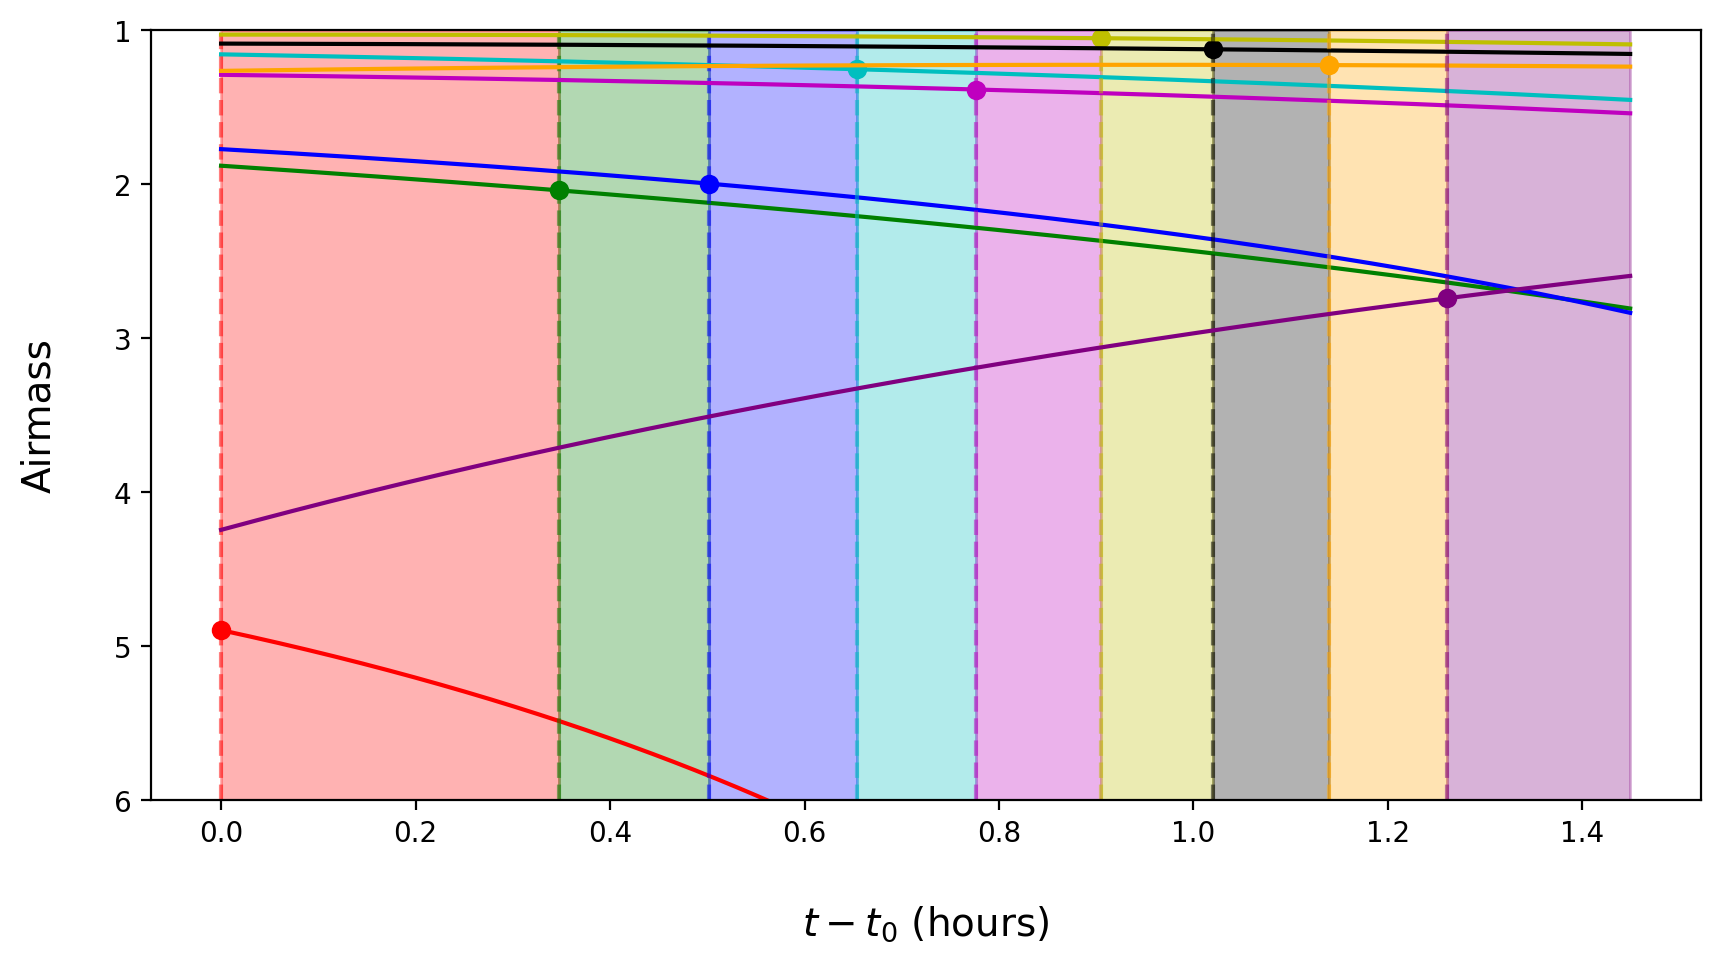

In [287]:
fig, ax = plt.subplots(figsize=(10, 5))
for idx, airmass in airmasses.items():
    ax.plot((times - times[0]) * 24, airmass, color=colors[idx])
    ax.axvline((fastest_epochs[idx] - times[0]) * 24, linestyle='--', alpha=0.5, color=colors[idx])

    # scatter a point where the airmass meets the vertical line
    ax.scatter((fastest_epochs[idx] - times[0]) * 24, airmass[np.argmin(abs(times - fastest_epochs[idx]))], color=colors[idx])


    # fill vertical spaces between fastest_epochs
    if idx < len(fastest_epochs) - 1:
        ax.axvspan((fastest_epochs[idx] - times[0]) * 24, (fastest_epochs[idx + 1] - times[0]) * 24, alpha=0.3, color=colors[idx])
    # fill vertical spaces between the final epoch and the end of the observation
    else:
        ax.axvspan((fastest_epochs[idx] - times[0]) * 24, (times[-1] - times[0]) * 24, alpha=0.3, color=colors[idx])

ax.invert_yaxis()
ax.set_ylim(6, 1)
ax.set_xlabel(r'$t - t_0$ (hours)', fontsize=14, labelpad=20)
ax.set_ylabel('Airmass', fontsize=14, labelpad=20)